# **Thermal Waves Experiment**
This jupyter notebook contains the data analysis for the thermal waves section of the script. It contains tasks 1.5 to 1.7.


In [161]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from data_utils import load_dataset, remove_transient
from collections import defaultdict
import re
import os
from IPython.display import Math, display

## **Plane Slab Model of the Cylinder**

The flow of heat in a medium is described by the **heat equation**, which for a plane slab (1-D system) is:

$$
\frac{\partial T(x,t)}{\partial t} = D \frac{\partial^2 T(x,t)}{\partial x^2}
$$

where $T(x,t)$ is the temperature in the medium as a function of space and time, and $D$ is the **thermal diffusivity** of the medium.

Equation (1.1) is a **diffusion equation**, which is a *linear differential equation* like Schrödinger’s equation and the wave equation in the *Electrical Waves* experiment.

---

### Analytical Solution

A solution for $T(x,t)$ that decays in space and oscillates in time with angular frequency $\omega$ is:

$$
T(x,t) = T_0 + C e^{-\sqrt{\frac{\omega}{2D}}\,x}
\sin\!\left(\sqrt{\frac{\omega}{2D}}\,x - \omega t + \phi_0 \right)
$$

where $T_0$, $C$, and $\phi_0$ are constants determined by initial and boundary conditions.

---

### Geometry of the Experiment

In the plane slab model, the brass cylinder is treated as a **1-dimensional slab** of thickness

$$
x_i = i\,\Delta d
$$

with the x-axis along the cylinder’s axis.  

Thermal waves propagate along the x-axis, and the thermistor sensors are placed every $\Delta d = 5~\text{mm}$.

We define $x = 0$ at the first thermistor.


In [162]:
delta_d = 5  # 5 mm spacing between thermistors

## **Task 1.5**

**a)** Write a Python script to extract the phase and amplitude of a single thermistor’s readings. Use this to determine the phase difference and attenuation between the $i = 0$ and $i = 3$ thermistors. Does it agree with your rough estimate from Task 1.4?

---

**b)** Repeat this for all thermistors and plot the attenuation factor against distance.

---

**c)** Find a theoretical form for this function using the plane wave model and fit it to your data to extract the thermal diffusivity, $D$.

---

**d)** Do the same for the phase lag, $\Delta \phi_i$.


#### **Task 1.5 (a) – Extract phase and amplitude from thermistors 0 and 3**
We will load up the $i = 0$ and $i = 3$ data and plot both to inspect form:

In [163]:
save_dir = "Thermal Wave Data"  # The folder that contains the data
files = ['brass_T10s_run1.csv', 'brass_T10s_run3.csv',
         'brass_T15s_run1.csv', 'brass_T15s_run2.csv',
         'brass_T20s_run1.csv', 'brass_T20s_run2.csv', 'brass_T20s_run3.csv',
         'brass_T30s_run1.csv', 'brass_T30s_run2.csv',
         'brass_T60s_run1.csv', 'brass_T60s_run2.csv']

In [164]:

path = os.path.join(save_dir, files[0])
timestamp, V, I, Temperatures, comments = load_dataset(path)

print(comments)
print(Temperatures.shape)

Period = 10
(8187, 8)


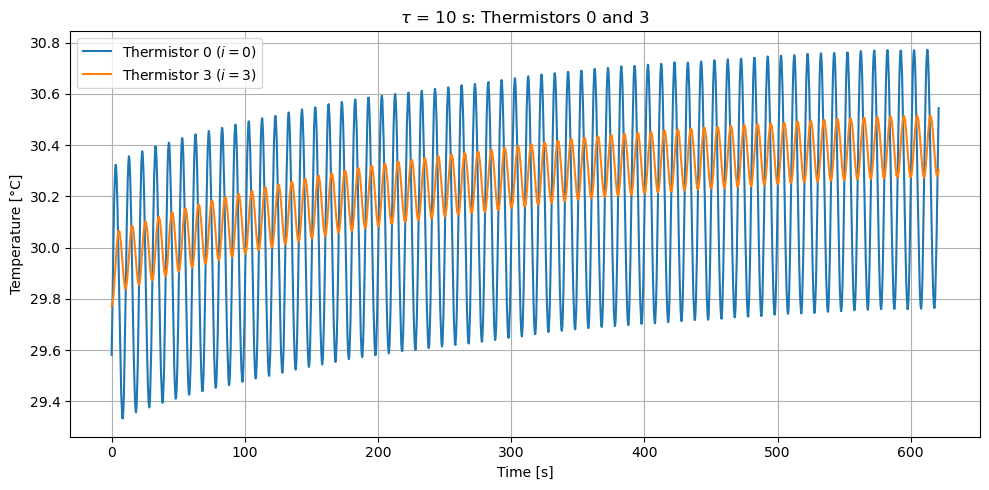

In [165]:
plt.figure(figsize=(10, 5))
plt.plot(timestamp, Temperatures[:, 0], label=r"Thermistor 0 ($i = 0$)")
plt.plot(timestamp, Temperatures[:, 3], label=r"Thermistor 3 ($i = 3$)")
plt.xlabel("Time [s]")
plt.ylabel("Temperature [°C]")
plt.title(r"$\tau$ = 10 s: Thermistors 0 and 3")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Detected stabilization at cycle 48 (t ≈ 480.0 s, removed 6328 samples, 77.3% of data).


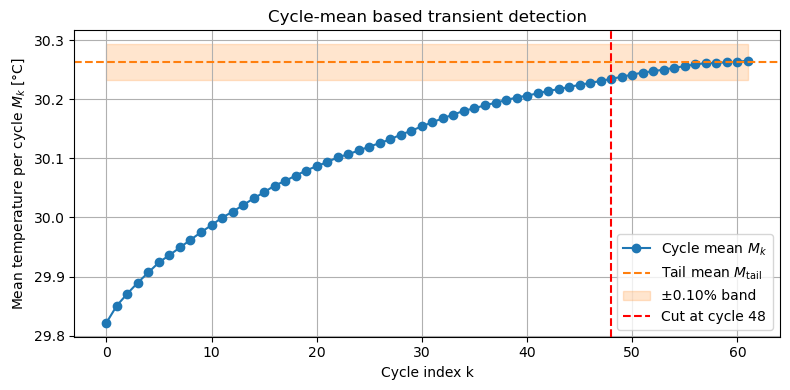

Detected stabilization at cycle 49 (t ≈ 490.0 s, removed 6460 samples, 78.9% of data).


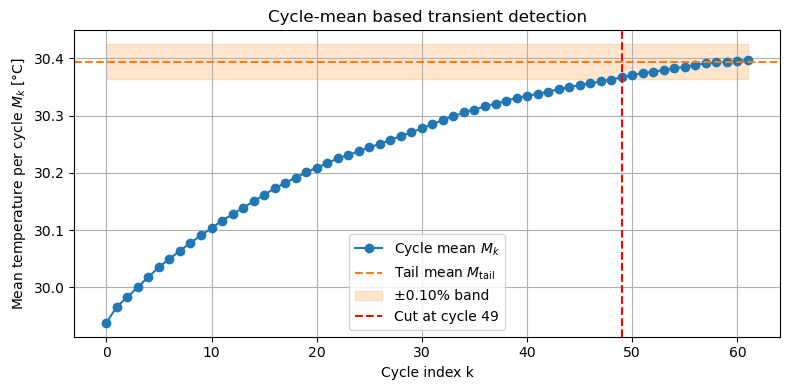

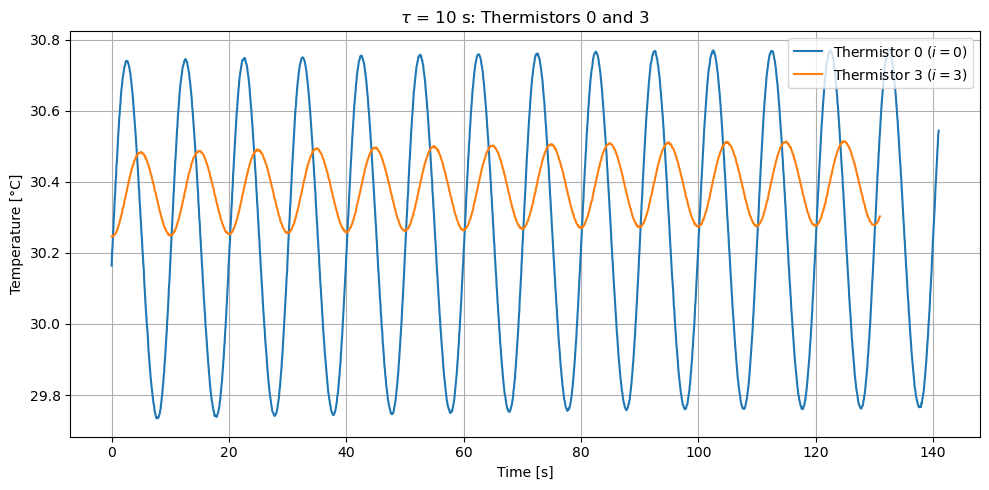

In [166]:
time_trunc_0, T_truc_0 = remove_transient(
    timestamp,
    Temperatures[:, 0],
    comments=comments,   # so it can read "Period = 10" etc.
    n_tail_cycles=5,
    frac_tol=0.001,      # e.g. ±0.5% in mean
    plot=True
)

time_trunc_3, T_truc_3 = remove_transient(
    timestamp,
    Temperatures[:, 3],
    comments=comments,   # so it can read "Period = 10" etc.
    n_tail_cycles=5,
    frac_tol=0.001,      # e.g. ±0.5% in mean
    plot=True
)




plt.figure(figsize=(10, 5))
plt.plot(time_trunc_0, T_truc_0, label=r"Thermistor 0 ($i = 0$)")
plt.plot(time_trunc_3, T_truc_3, label=r"Thermistor 3 ($i = 3$)")
plt.xlabel("Time [s]")
plt.ylabel("Temperature [°C]")
plt.title(r"$\tau$ = 10 s: Thermistors 0 and 3")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

We will now define functions to extract the amplitude and phase from a single thermistor:

In [167]:
def plane_wave_model(t, T0, A, phi, omega):
    return T0 + A * np.sin(omega * t + phi)

def planewave_curvefit(t, y, omega=None, comments=None):
    
    # Function will detect the time period from the comments
    if comments is not None and omega is None:
        T_match = re.search(r"Period\s*=\s*([\d.]+)", comments)
        if not T_match:
            raise ValueError("Couldn't find time period in comments.")
        T = float(T_match.group(1))
        omega = 2 * np.pi / T
 
    # Initial guesses
    T0_guess  = np.mean(y)
    A_guess   = 0.5 * (np.percentile(y,95) - np.percentile(y,5))
    phi_guess = 0.0

    popt, pcov = curve_fit(
        lambda tt, T0, A, phi: plane_wave_model(tt, T0, A, phi, omega),
        t, y,
        p0=[T0_guess, A_guess, phi_guess],
        maxfev=10000
    )
    
    T0, A, phi = popt
    unc_T0, unc_A, unc_phi = np.sqrt(np.diag(pcov))

    # Enforce A ≥ 0
    if A < 0:
        A = -A
        phi = phi + np.pi

    return (T0, unc_T0), (A, unc_A), (phi, unc_phi), omega

In [168]:
(T0_0, unc_T0_0), (A0, unc_A0), (phi0, unc_phi0), omega = planewave_curvefit(time_trunc_0, T_truc_0, comments=comments)

(T0_3, unc_T0_3), (A3, unc_A3), (phi3, unc_phi3), omega = planewave_curvefit(time_trunc_3, T_truc_3, comments=comments)
print()

display(Math(rf"A_0 = {A0:.4f} \pm {unc_A0:.4f}\ \text{{°C}}"))
display(Math(rf"\phi_0 = {phi0:.4f} \pm {unc_phi0:.4f}\ \text{{rad}}"))
display(Math(""))
display(Math(rf"A_3 = {A3:.4f} \pm {unc_A3:.4f}\ \text{{°C}}"))
display(Math(rf"\phi_3 = {phi3:.4f} \pm {unc_phi3:.4f}\ \text{{rad}}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

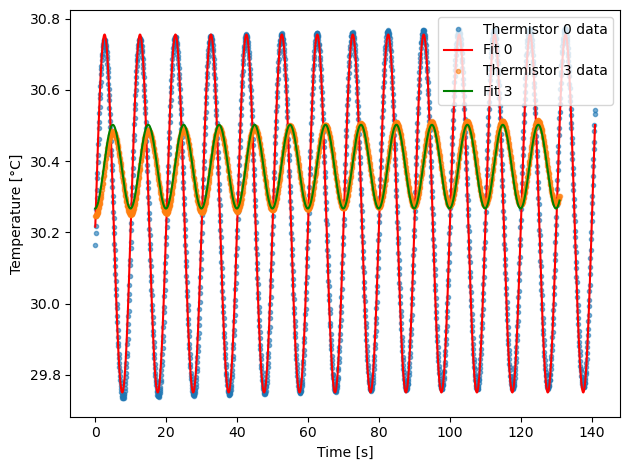

In [169]:
plt.plot(time_trunc_0, T_truc_0, '.', label='Thermistor 0 data', alpha=0.6)
plt.plot(time_trunc_0, plane_wave_model(time_trunc_0, T0_0, A0, phi0, omega), 'r-', label='Fit 0')

plt.plot(time_trunc_3, T_truc_3, '.', label='Thermistor 3 data', alpha=0.6)
plt.plot(time_trunc_3, plane_wave_model(time_trunc_3, T0_3, A3, phi3, omega), 'g-', label='Fit 3')

plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.legend()
plt.tight_layout()
plt.show()

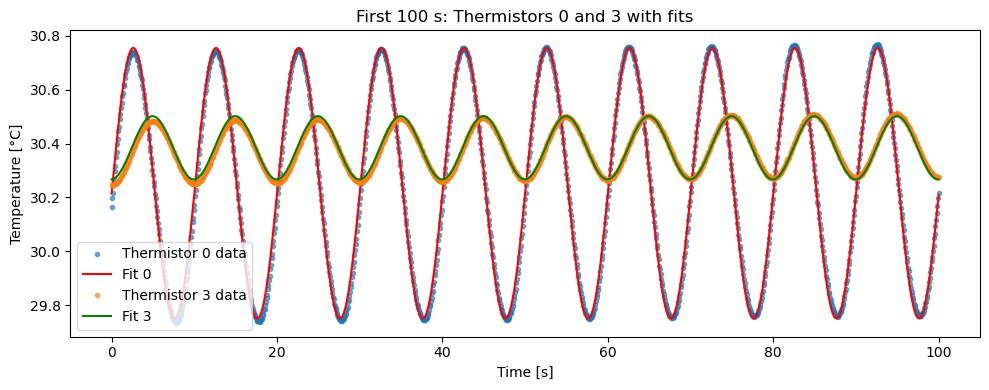

In [170]:
# Mask for first 100 seconds
mask0_100 = time_trunc_0 <= 100
mask3_100 = time_trunc_3 <= 100

t0_100  = time_trunc_0[mask0_100]
t3_100  = time_trunc_3[mask3_100]
T0_100  = T_truc_0[mask0_100]  # thermistor 0
T3_100  = T_truc_3[mask3_100]  # thermistor 3

plt.figure(figsize=(10, 4))

plt.plot(t0_100, T0_100, '.', label='Thermistor 0 data', alpha=0.6)
plt.plot(t0_100, plane_wave_model(t0_100, T0_0, A0, phi0, omega),
         'r-', label='Fit 0')

plt.plot(t3_100, T3_100, '.', label='Thermistor 3 data', alpha=0.6)
plt.plot(t3_100, plane_wave_model(t3_100, T0_3, A3, phi3, omega),
         'g-', label='Fit 3')

plt.xlabel('Time [s]')
plt.ylabel('Temperature [°C]')
plt.title('First 100 s: Thermistors 0 and 3 with fits')
plt.legend()
plt.tight_layout()
plt.show()


Define functions to determine attenuation factor and phase difference:

In [171]:
def attenuation_factor(A1, unc_A1, A2, unc_A2):
    g = A2 / A1
    unc_g = g * np.sqrt((unc_A2/A2)**2 + (unc_A1/A1)**2)
    return g, unc_g

def phase_difference(phi1, unc_phi1, phi2, unc_phi2):
    dphi = phi2 - phi1
    unc_dphi = np.sqrt(unc_phi1**2 + unc_phi2**2)
    return dphi, unc_dphi

In [172]:
g, unc_g = attenuation_factor(A0, unc_A0, A3, unc_A3)
dphi, unc_dphi = phase_difference(phi0, unc_phi0, phi3, unc_phi3)

display(Math(rf"\gamma_3 = {g:.4f} \pm {unc_g:.4f}"))
display(Math(rf"\Delta\phi_3 = {dphi:.4f} \pm {unc_dphi:.4f}\ \text{{rad}}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [173]:
D_gamma_3 = (omega*(3*delta_d)**2) / (2*(np.log(g))**2)
D_phi_3 = (omega*(3*delta_d)**2) / (2*(dphi)**2)

display(Math(rf"T = 10\,\text{{s}}\,,\,\, i = 3:"))
display(Math(rf"D_\gamma = {D_gamma_3:.4f}\, \text{{mm}}^2/\text{{s}}"))
display(Math(rf"D_\phi = {D_phi_3:.4f}\, \text{{mm}}^2/\text{{s}}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### **Task 1.5 (b) – Extract transmission factor for all thermistors and plot them**
We now fit **all thermistors** with the same sinusoidal model to extract their
amplitudes $A_i$ and phases $\phi_i$, then compute the attenuation factor
$\gamma_i = A_i / A_0$ and plot it against distance $x_i = i \Delta d$.

Detected stabilization at cycle 48 (t ≈ 480.0 s, removed 6328 samples, 77.3% of data).


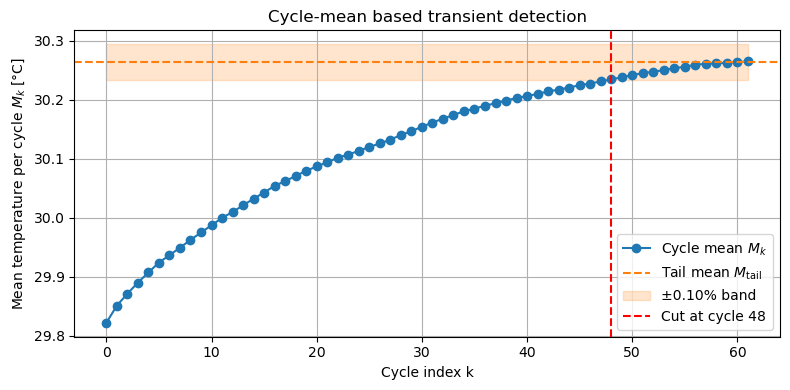

Detected stabilization at cycle 49 (t ≈ 490.0 s, removed 6460 samples, 78.9% of data).


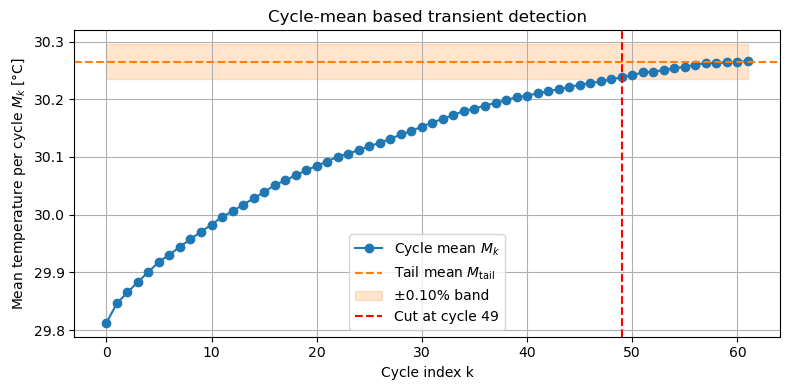

Detected stabilization at cycle 49 (t ≈ 490.0 s, removed 6460 samples, 78.9% of data).


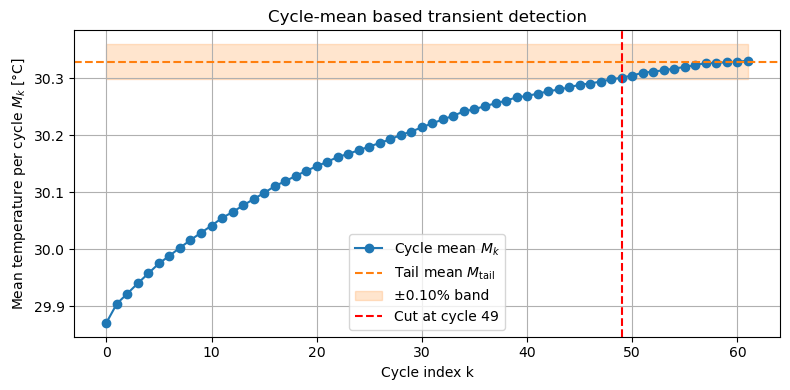

Detected stabilization at cycle 49 (t ≈ 490.0 s, removed 6460 samples, 78.9% of data).


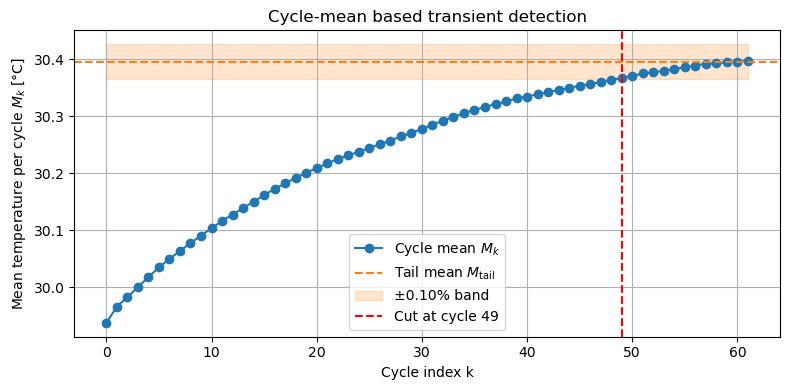

Detected stabilization at cycle 49 (t ≈ 490.0 s, removed 6460 samples, 78.9% of data).


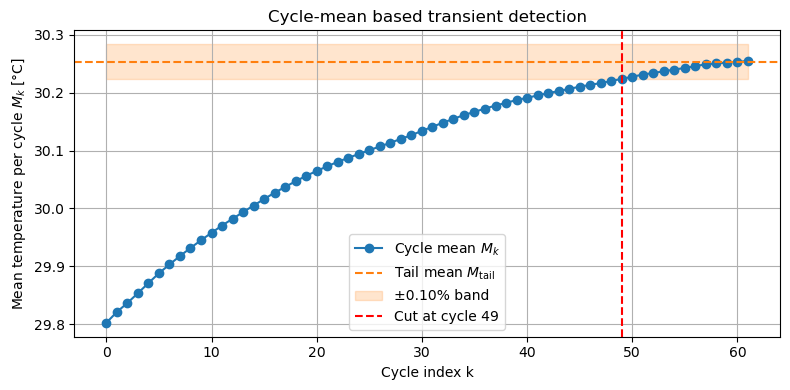

Detected stabilization at cycle 49 (t ≈ 490.0 s, removed 6460 samples, 78.9% of data).


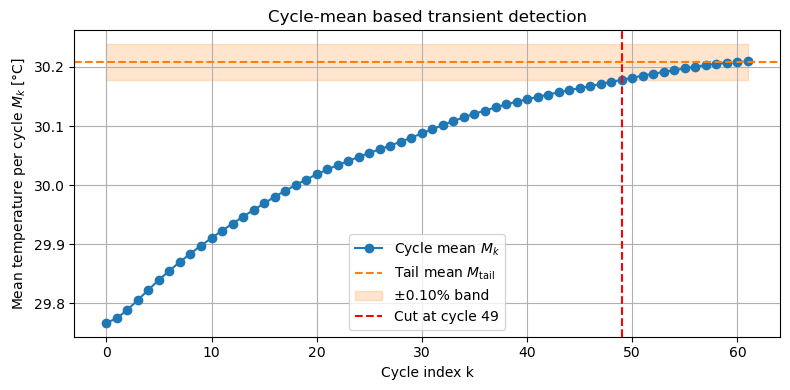

Detected stabilization at cycle 50 (t ≈ 500.1 s, removed 6592 samples, 80.5% of data).


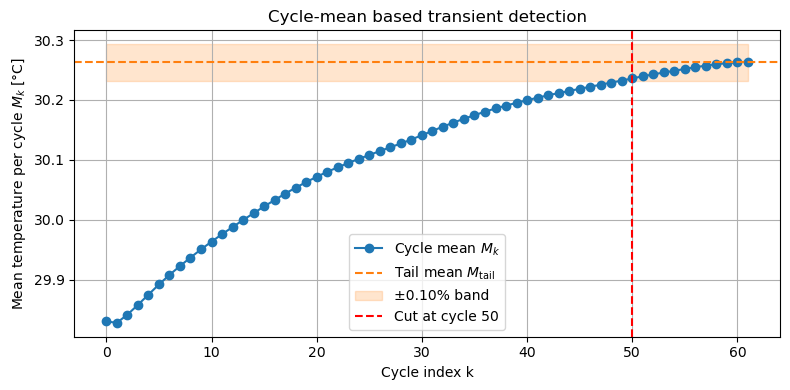

Amplitudes A_i: [0.50223215 0.30399478 0.18231632 0.11751297 0.0682995  0.04118542
 0.02785659]

Phases phi_i  : [-0.07391726 -0.57428619 -1.11993963 -1.53070542 -2.05175945 -2.59770908
 -3.18765453]


In [174]:
n_therm = Temperatures.shape[1] - 1

amps = np.zeros(n_therm)
unc_amps = np.zeros(n_therm)
phases = np.zeros(n_therm)
unc_phases = np.zeros(n_therm)

for i in range(n_therm):
    # Truncate data to remove transients for each thermistor
    
    t_trunc, T_trunc = remove_transient(
    timestamp,
    Temperatures[:, i],
    comments=comments,   # so it can read "Period = 10" etc.
    n_tail_cycles=3,
    frac_tol=0.001,      # e.g. ±0.5% in mean
    plot=True, 
    verbose=True
)

    (_, _), (A, unc_A), (phi, unc_phi), omega = planewave_curvefit(
        t_trunc, T_trunc,
        comments=comments      # auto-detect the period
    )


    amps[i] = A
    unc_amps[i] = unc_A
    phases[i] = phi
    unc_phases[i] = unc_phi

phases = np.unwrap(phases)

print("Amplitudes A_i:", amps)
print()
print("Phases phi_i  :", phases)


In [175]:
# Thermistor indices and distances
i_vals = np.arange(n_therm)  # i = 0,1,2,...
x = i_vals * delta_d  # delta_d = 5 mm

# Attenuation factors
gamma = amps / amps[0]
unc_gamma = gamma * np.sqrt(
    (unc_amps / amps) ** 2 + (unc_amps[0] / amps[0]) ** 2)

# Taking natural logs ln(γ_i)
ln_gamma = np.log(gamma)
unc_ln_gamma = unc_gamma/gamma

# Compute phase lag relative to thermistor 0
dphi = phases - phases[0]
unc_dphi = np.sqrt(unc_phases**2 + unc_phases[0]**2)


print("Attenuation Factors:", gamma)
print("Phase Lags:", dphi)


Attenuation Factors: [1.         0.60528737 0.36301204 0.23398139 0.1359919  0.08200475
 0.05546557]
Phase Lags: [ 0.         -0.50036893 -1.04602236 -1.45678815 -1.97784218 -2.52379181
 -3.11373726]


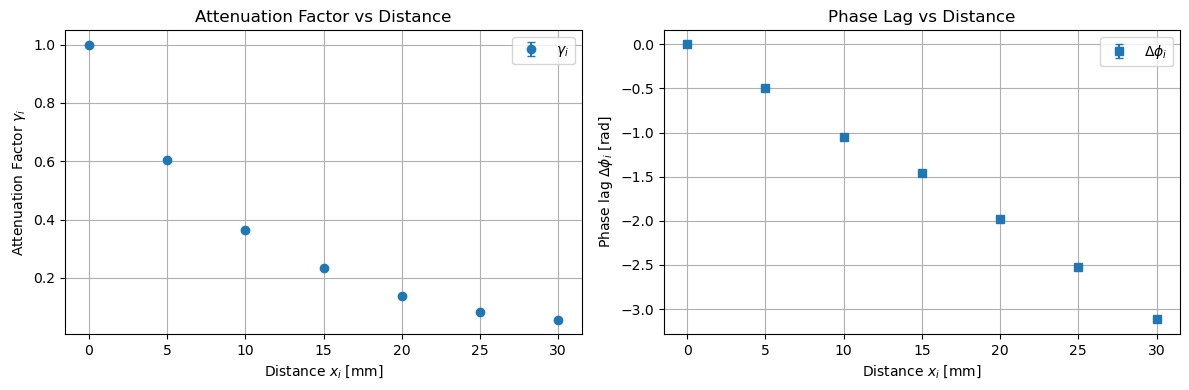

In [176]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Left Plot: Attenuation Factor vs Distance
ax = axes[0]
ax.errorbar(
    x, gamma,
    yerr = unc_gamma,
    fmt = 'o', capsize=3,
    label = r'$\gamma_i$')

ax.set_xlabel(r"Distance $x_i$ [mm]")
ax.set_ylabel(r"Attenuation Factor $\gamma_i$")
ax.set_title("Attenuation Factor vs Distance")
ax.grid(True)
ax.legend()

# Right Plot: Phase-lag vs Distance
ax = axes[1]
ax.errorbar(
    x, dphi,
    yerr=unc_dphi,
    fmt='s', capsize=3,
    label=r'$\Delta\phi_i$',)

ax.set_xlabel(r"Distance $x_i$ [mm]")
ax.set_ylabel(r"Phase lag $\Delta\phi_i$ [rad]")
ax.set_title("Phase Lag vs Distance")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()


#### **Task 1.5 (c) – Fit attenuation vs distance to extract $D_\gamma$**

From the plane-wave solution, the attenuation factor 

$$
\ln(\gamma_i) = -\sqrt{\frac{\omega}{2D}} \, (i\Delta d)
$$

where $x_i = i \Delta d$, so we fit

$$
\ln(\gamma_i) = k_{\gamma} \, x_i
$$

and compute the diffusivity:

$$
D = \frac{\omega}{2 k_{\gamma}^2}.
$$

---

#### **Task 1.5 (d) – Fit phase lag vs distance to extract $D_\phi$**

The theoretical phase lag is

$$
\Delta\phi_i = \sqrt{\frac{\omega}{2D}} \, (i\Delta d),
$$

where $x_i = i \Delta d$, so we fit

$$
\Delta\phi_i = k_{\phi} \, x_i.
$$

Thus,

$$
D = \frac{\omega}{2 k_{\phi}^2}.
$$


In [177]:
def linear(x, k, c):
    return k * x + c

In [178]:
# Apply linear fit to ln(gamma) vs distance
popt_gamma, pcov_gamma = curve_fit(
    linear,
    x,
    ln_gamma,
    sigma = unc_ln_gamma,
    absolute_sigma = True,
    maxfev=10000
)
k_gamma, c_gamma = popt_gamma
unc_k_gamma, unc_c_gamma = np.sqrt(np.diag(pcov_gamma))

# Apply linear fit to phase lag vs distance
popt_phi, pcov_phi = curve_fit(
    linear,
    x,
    dphi,
    sigma=unc_dphi,
    absolute_sigma=True,
    maxfev=10000
)
k_phi, c_phi = popt_phi
unc_k_phi, unc_c_phi = np.sqrt(np.diag(pcov_phi))

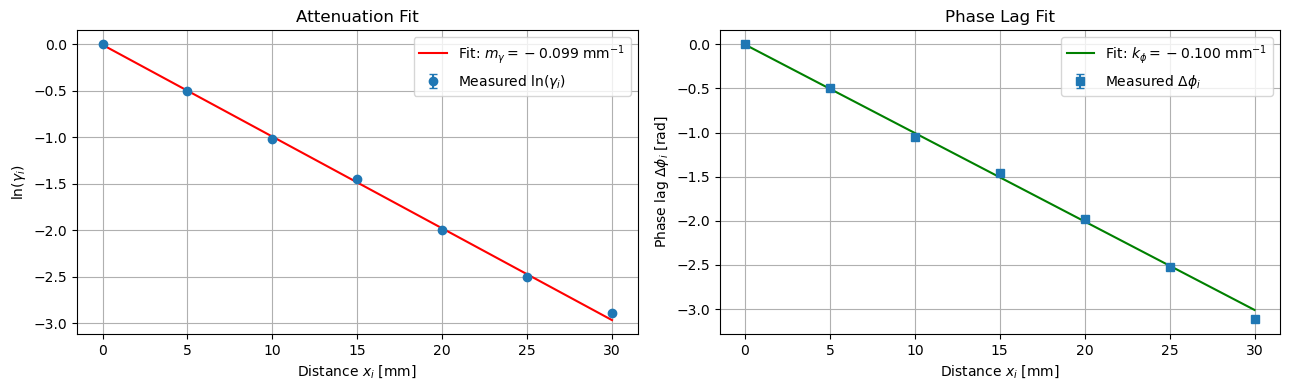

In [179]:
# Plot both fits on with the data

x_dense = np.linspace(x.min(), x.max(), 300)

fig, axes = plt.subplots(1, 2, figsize=(13, 4))

# ----- Left: Attenuation fit -----
ax = axes[0]
ax.errorbar(
    x, ln_gamma,
    yerr=unc_ln_gamma,
    fmt='o', capsize=3,
    label=r'Measured $\ln(\gamma_i)$'
)
ax.plot(
    x_dense,
    linear(x_dense, k_gamma, c_gamma),
    'r-',
    label=rf'Fit: $m_\gamma = {k_gamma:.3f}$ mm$^{{-1}}$'
)
ax.set_xlabel(r"Distance $x_i$ [mm]")
ax.set_ylabel(r"$\ln(\gamma_i)$")
ax.set_title("Attenuation Fit")
ax.grid(True)
ax.legend()

# Right Plot: Phase-lag fit
ax = axes[1]
ax.errorbar(
    x, dphi,
    yerr = unc_dphi,
    fmt = 's', capsize = 3,
    label = r'Measured $\Delta\phi_i$'
)
ax.plot(
    x_dense,
    linear(x_dense, k_phi, c_phi),
    'g-',
    label=rf'Fit: $k_\phi = {k_phi:.3f}$ mm$^{{-1}}$'
)
ax.set_xlabel(r"Distance $x_i$ [mm]")
ax.set_ylabel(r"Phase lag $\Delta\phi_i$ [rad]")
ax.set_title("Phase Lag Fit")
ax.grid(True)
ax.legend()

plt.tight_layout()
plt.show()

In [180]:
# Diffusivity from transmission factor (mm^2/s)
D_gamma = omega / (2 * k_gamma ** 2)
unc_D_gamma = np.abs(-omega / (k_gamma ** 3)) * unc_k_gamma

# Diffusivity from phase (mm^2/s)
D_phi = omega / (2 * k_phi ** 2)
unc_D_phi = np.abs(-omega / (k_phi ** 3)) * unc_k_phi

# Display results
display(Math(rf"D_\gamma = {D_gamma:.3f} \pm {unc_D_gamma:.3f}\ \text{{mm}}^2/\text{{s}}"))
display(Math(rf"D_\phi = {D_phi:.3f} \pm {unc_D_phi:.3f}\ \text{{mm}}^2/ \text{{s}}"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## **Task 1.6**

**a)** Send sine wave of different periods, e.g. 15s, 20s, 30s, 60s. Repeat each dataset a few times and use this to estimate the noise level on your extracted phase and amplitudes. Don’t forget to let the temperatures stabilize! 

---

**b)** Plot the attenuation and phase lags for each frequency and extract estimates of D for each frequency with each method. How well does the model work at all these frequencies?




#### **Task 1.6 (b) – Using multiple frequencies to determine $D(\omega)$**

We first define a function to analyse a single dataset which returns arrays of $\gamma_i$ and $\Delta\phi_i$ and their uncertainties:

In [181]:
def analyse_dataset(path):

    # Load dataset
    timestamp, V, I, Temperatures, comments = load_dataset(path)
    n_therm = Temperatures.shape[1] - 1

    # Arrays for amplitudes and phases
    amps = np.zeros(n_therm)
    unc_amps = np.zeros(n_therm)
    phases = np.zeros(n_therm)
    unc_phases = np.zeros(n_therm)

    # Fit each thermistor
    for i in range(n_therm):
        print (rf"Thermistor {i}")
        t_trunc, T_trunc = remove_transient(
            timestamp,
            Temperatures[:, i],
            comments=comments,   # so it can read "Period = 10" etc.
            n_tail_cycles=4,
            frac_tol=0.001,      # e.g. ±0.5% in mean
            plot=True, 
            verbose=True
        )

        (_, _), (A, unc_A), (phi, unc_phi), omega = planewave_curvefit(
            t_trunc, T_trunc,
            comments=comments  # auto-detect Period
        )

        amps[i] = A
        unc_amps[i] = unc_A
        phases[i] = phi
        unc_phases[i] = unc_phi

    # Unwrap phases across thermistors
    phases = np.unwrap(phases)

    # Transmission factors γ_i = A_i / A_0
    gamma = amps / amps[0]
    unc_gamma = gamma * np.sqrt(
        (unc_amps / amps) ** 2 +
        (unc_amps[0] / amps[0]) ** 2
    )

    # Phase lags Δφ_i = φ_i - φ_0
    dphi = phases - phases[0]
    unc_dphi = np.sqrt(unc_phases ** 2 + unc_phases[0] ** 2)

    return omega, gamma, unc_gamma, dphi, unc_dphi

We now create a loop to index through each data set and determine the transmission factors and phase lags. We will then average over each run to calculate the statistical uncertainty for each frequency. Then we will determine the diffusivity of the material using the either of $\gamma$ or $\Delta\Phi$ using the linear fit we defined above. Our plane wave model assumes that the diffusivity is independent of the driving frequency. In reality we should see the plane wave model break down for low frequencies (high time periods). Hence, we will plot diffusivity as a function of the angular frequency $D(\omega)$ to determine what range of frequencies our model works over. As an extention we could use the full solution composed for both the upwards and downwards travelling compolex waves and take the real part to find the $T(x, t)$:

$$T(x, t) = \left( C_{+}e^{\beta x} + C_{-}e^{-\beta x}\right)\,e^{i\omega t}  $$


File: brass_T10s_run1.csv
Thermistor 0
Detected stabilization at cycle 48 (t ≈ 480.0 s, removed 6328 samples, 77.3% of data).


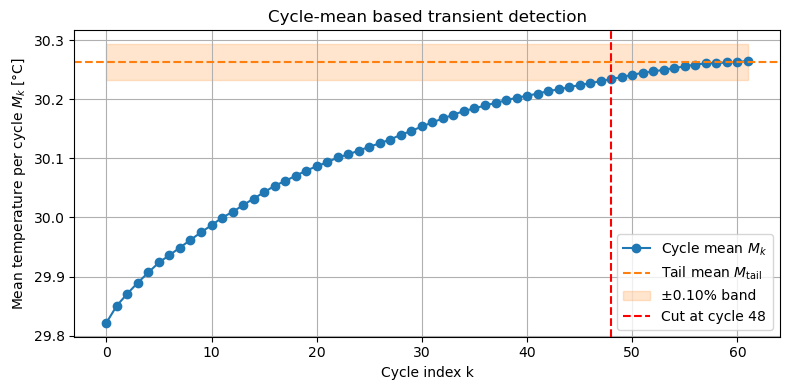

Thermistor 1
Detected stabilization at cycle 48 (t ≈ 480.0 s, removed 6328 samples, 77.3% of data).


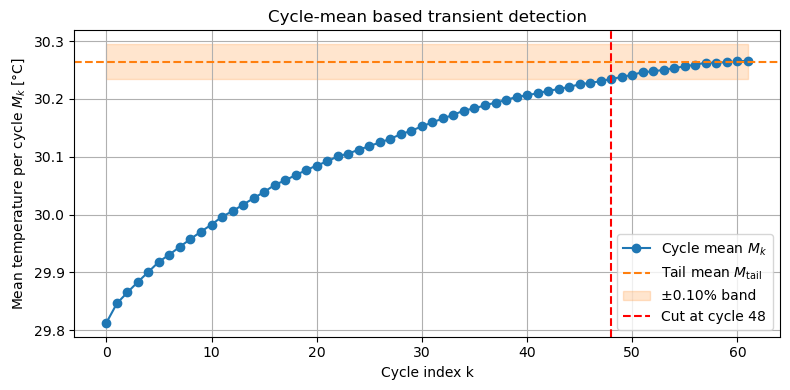

Thermistor 2
Detected stabilization at cycle 49 (t ≈ 490.0 s, removed 6460 samples, 78.9% of data).


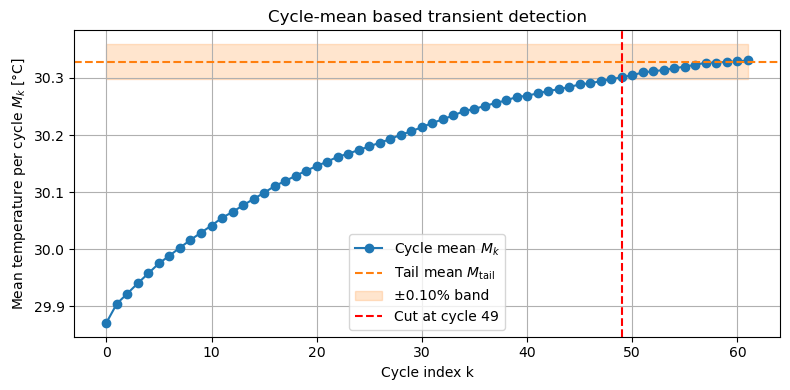

Thermistor 3
Detected stabilization at cycle 49 (t ≈ 490.0 s, removed 6460 samples, 78.9% of data).


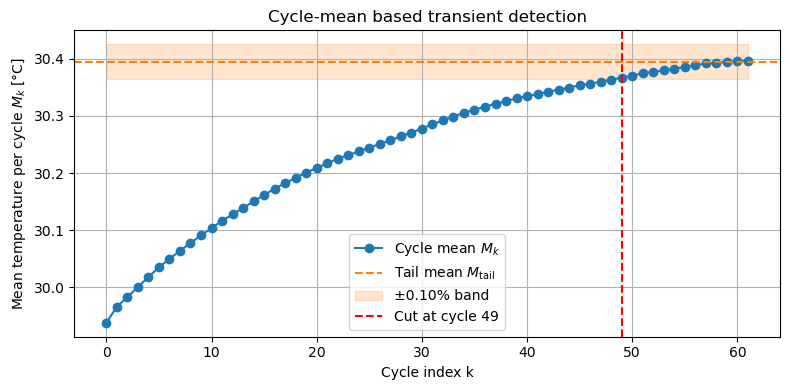

Thermistor 4
Detected stabilization at cycle 49 (t ≈ 490.0 s, removed 6460 samples, 78.9% of data).


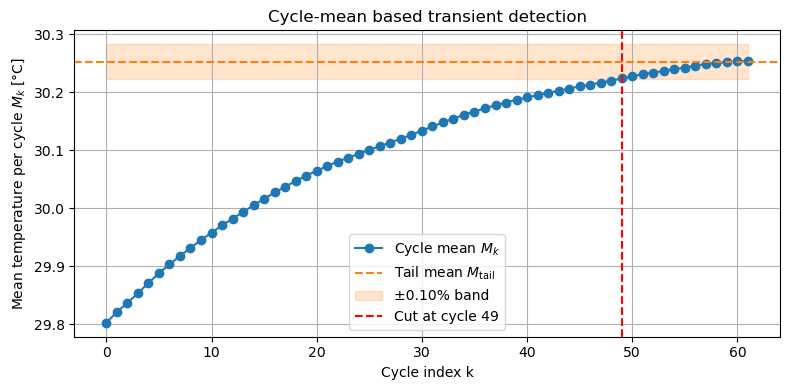

Thermistor 5
Detected stabilization at cycle 49 (t ≈ 490.0 s, removed 6460 samples, 78.9% of data).


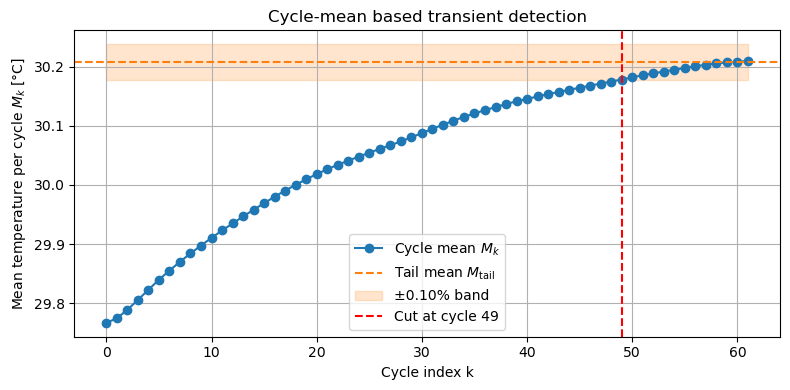

Thermistor 6
Detected stabilization at cycle 49 (t ≈ 490.0 s, removed 6460 samples, 78.9% of data).


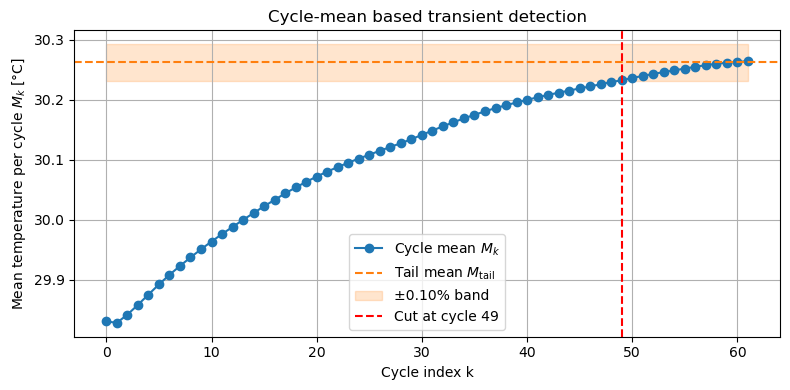

File: brass_T10s_run3.csv
Thermistor 0
Detected stabilization at cycle 56 (t ≈ 560.0 s, removed 7381 samples, 86.0% of data).


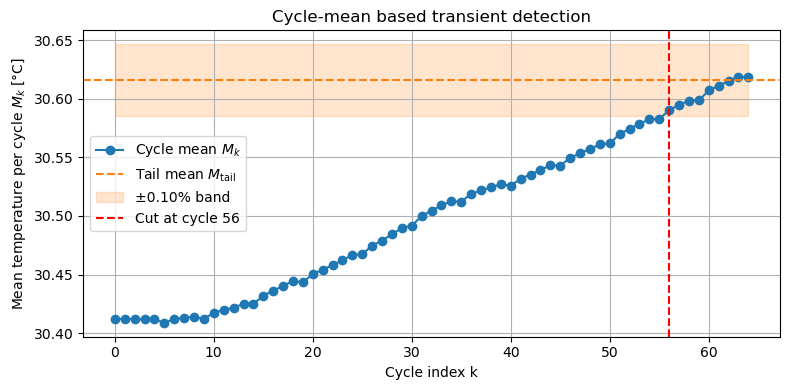

Thermistor 1
Detected stabilization at cycle 56 (t ≈ 560.0 s, removed 7381 samples, 86.0% of data).


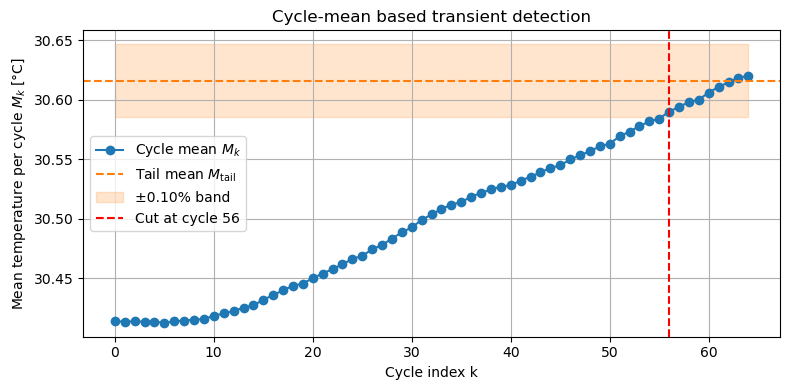

Thermistor 2
Detected stabilization at cycle 56 (t ≈ 560.0 s, removed 7381 samples, 86.0% of data).


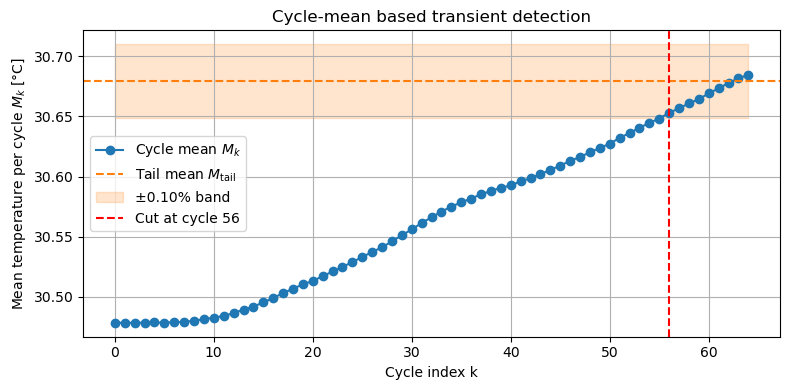

Thermistor 3
Detected stabilization at cycle 55 (t ≈ 550.1 s, removed 7250 samples, 84.5% of data).


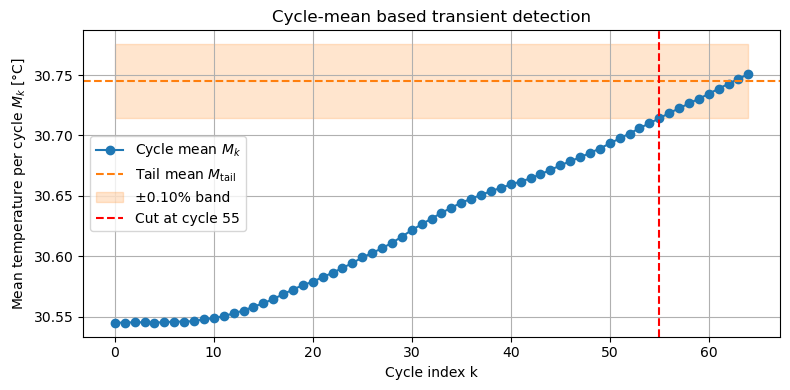

Thermistor 4
Detected stabilization at cycle 55 (t ≈ 550.1 s, removed 7250 samples, 84.5% of data).


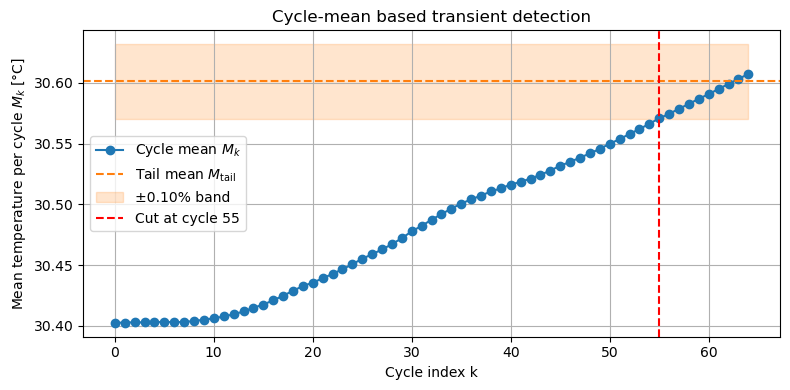

Thermistor 5
Detected stabilization at cycle 55 (t ≈ 550.1 s, removed 7250 samples, 84.5% of data).


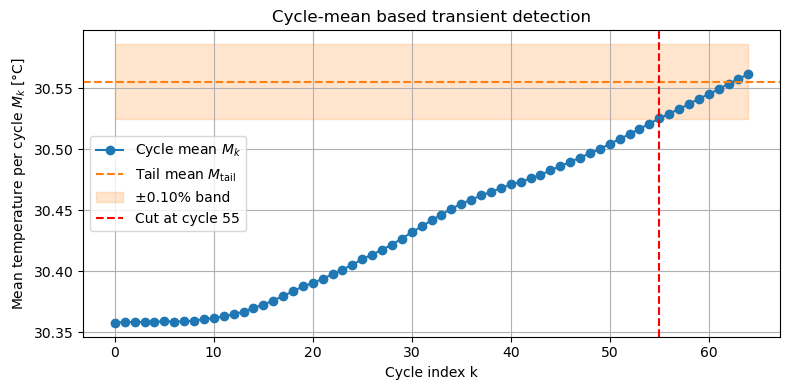

Thermistor 6
Detected stabilization at cycle 55 (t ≈ 550.1 s, removed 7250 samples, 84.5% of data).


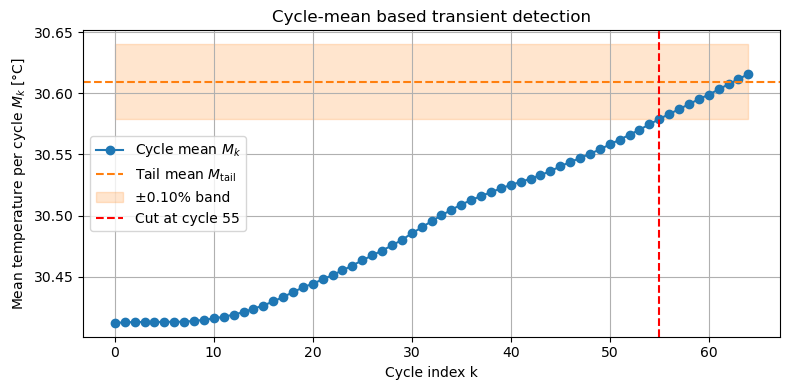

File: brass_T15s_run1.csv
Thermistor 0
Detected stabilization at cycle 35 (t ≈ 525.0 s, removed 6920 samples, 87.4% of data).


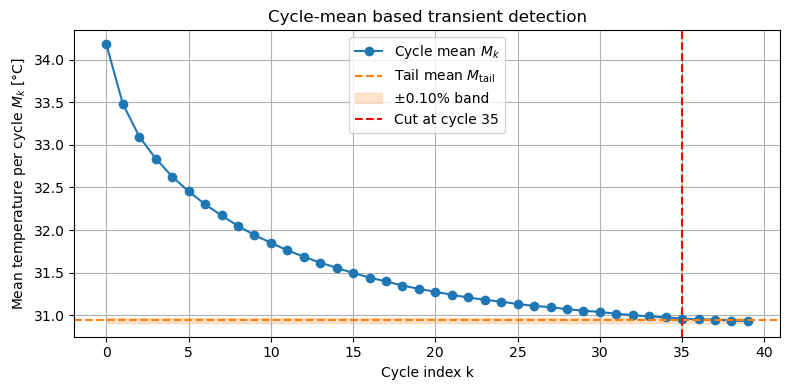

Thermistor 1
Detected stabilization at cycle 35 (t ≈ 525.0 s, removed 6920 samples, 87.4% of data).


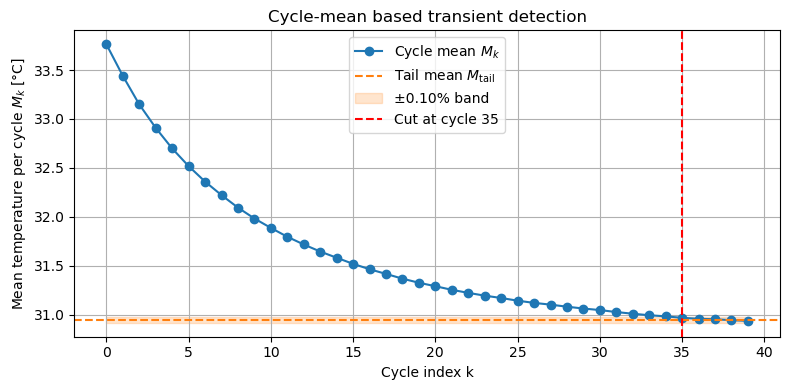

Thermistor 2
Detected stabilization at cycle 35 (t ≈ 525.0 s, removed 6920 samples, 87.4% of data).


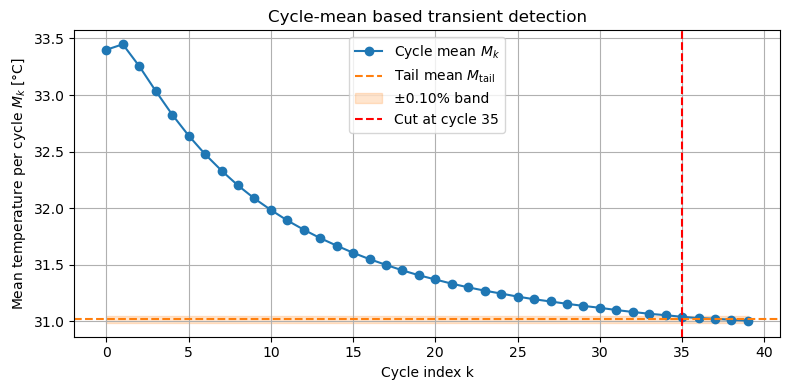

Thermistor 3
Detected stabilization at cycle 35 (t ≈ 525.0 s, removed 6920 samples, 87.4% of data).


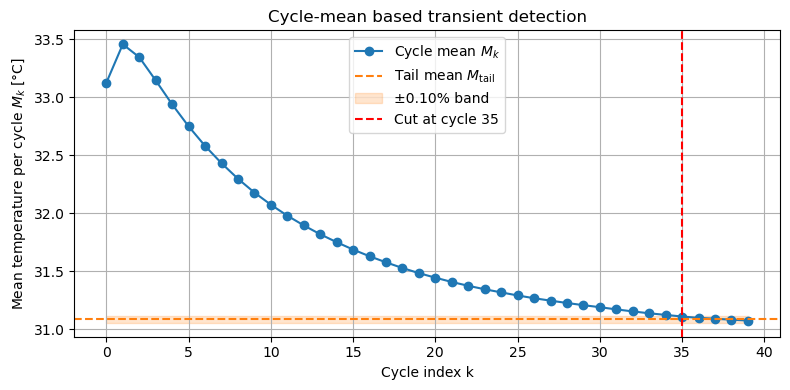

Thermistor 4
Detected stabilization at cycle 35 (t ≈ 525.0 s, removed 6920 samples, 87.4% of data).


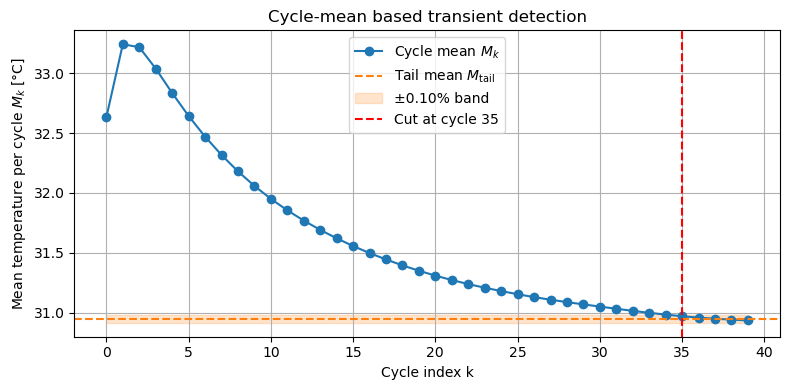

Thermistor 5
Detected stabilization at cycle 35 (t ≈ 525.0 s, removed 6920 samples, 87.4% of data).


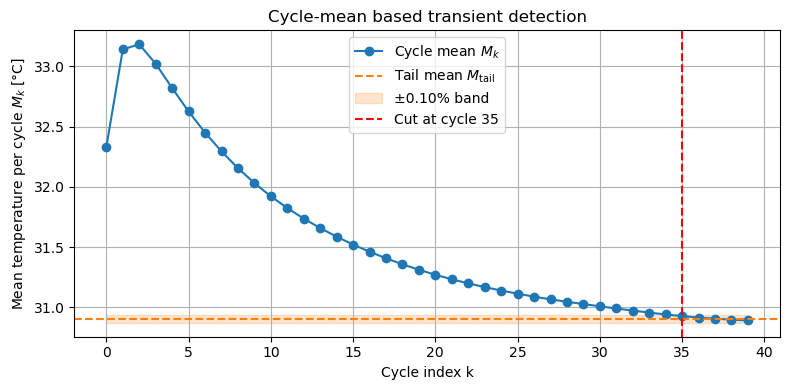

Thermistor 6
Detected stabilization at cycle 35 (t ≈ 525.0 s, removed 6920 samples, 87.4% of data).


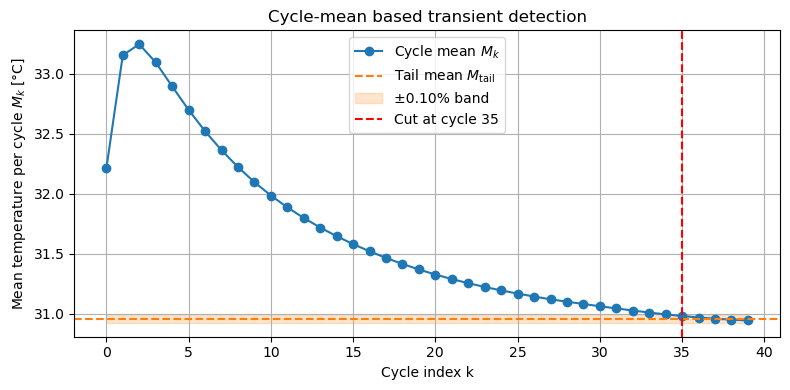

File: brass_T15s_run2.csv
Thermistor 0
Detected stabilization at cycle 3 (t ≈ 45.1 s, removed 594 samples, 18.7% of data).


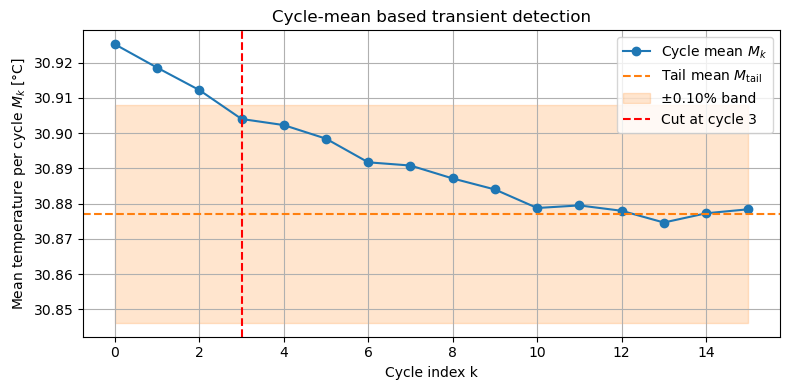

Thermistor 1
Detected stabilization at cycle 3 (t ≈ 45.1 s, removed 594 samples, 18.7% of data).


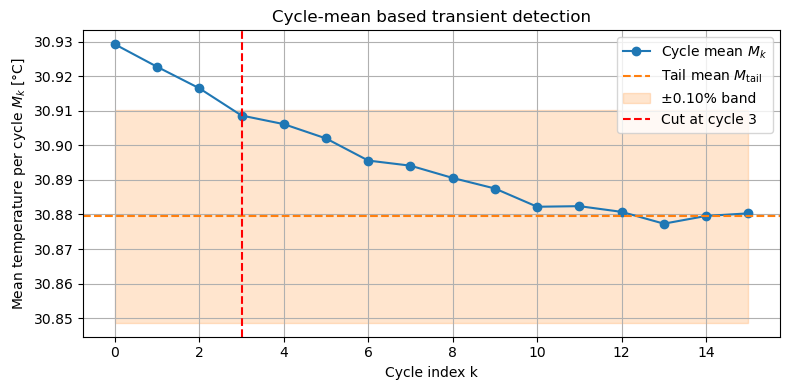

Thermistor 2
Detected stabilization at cycle 4 (t ≈ 60.0 s, removed 791 samples, 24.9% of data).


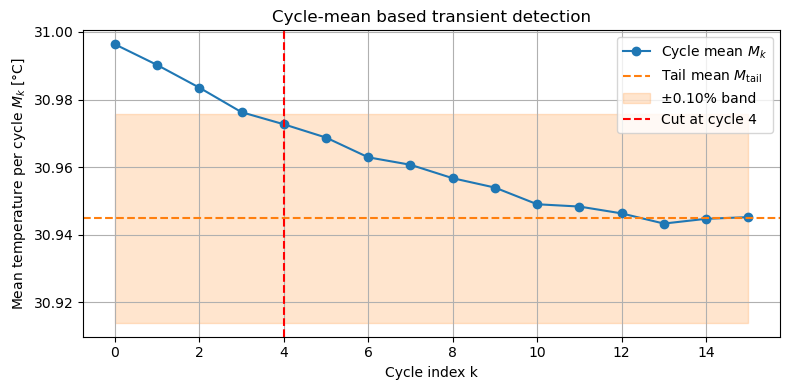

Thermistor 3
Detected stabilization at cycle 4 (t ≈ 60.0 s, removed 791 samples, 24.9% of data).


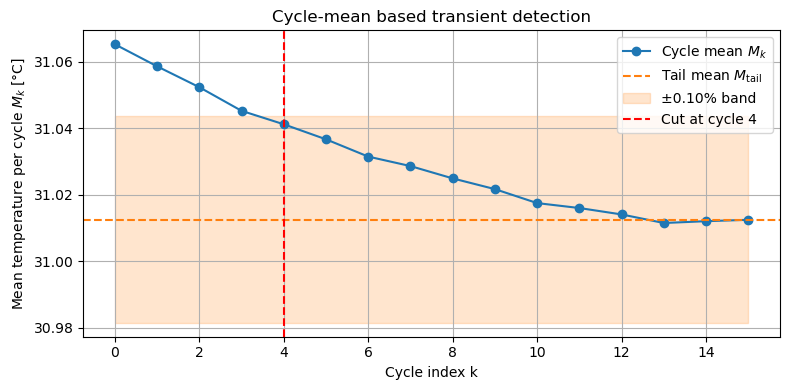

Thermistor 4
Detected stabilization at cycle 4 (t ≈ 60.0 s, removed 791 samples, 24.9% of data).


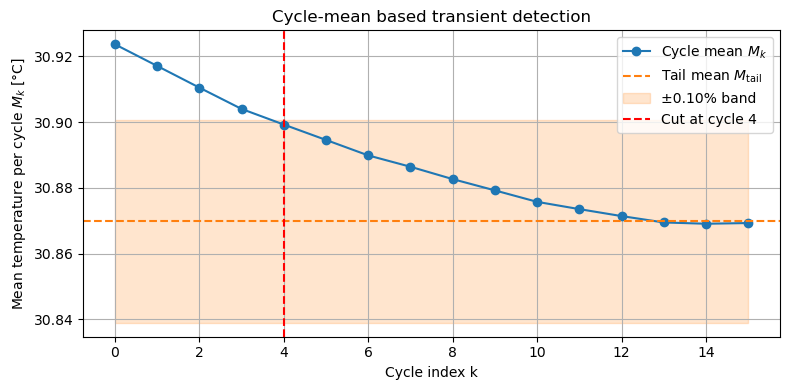

Thermistor 5
Detected stabilization at cycle 4 (t ≈ 60.0 s, removed 791 samples, 24.9% of data).


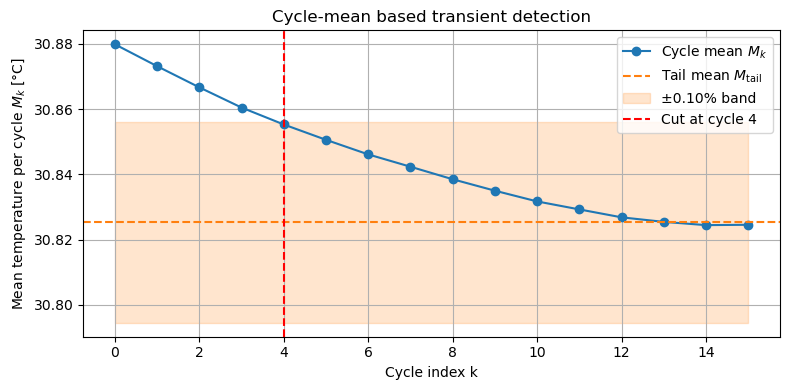

Thermistor 6
Detected stabilization at cycle 4 (t ≈ 60.0 s, removed 791 samples, 24.9% of data).


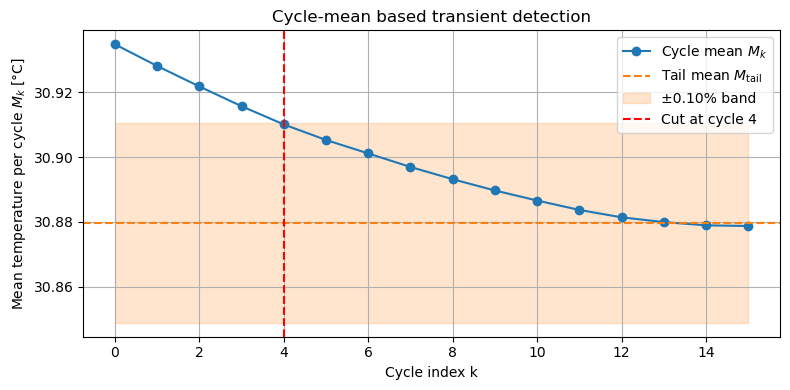

File: brass_T20s_run1.csv
Thermistor 0
Detected stabilization at cycle 6 (t ≈ 120.1 s, removed 1583 samples, 24.0% of data).


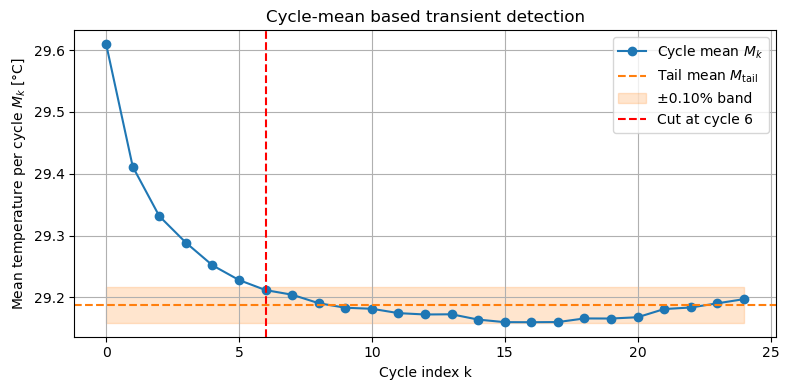

Thermistor 1
Detected stabilization at cycle 7 (t ≈ 140.1 s, removed 1847 samples, 28.0% of data).


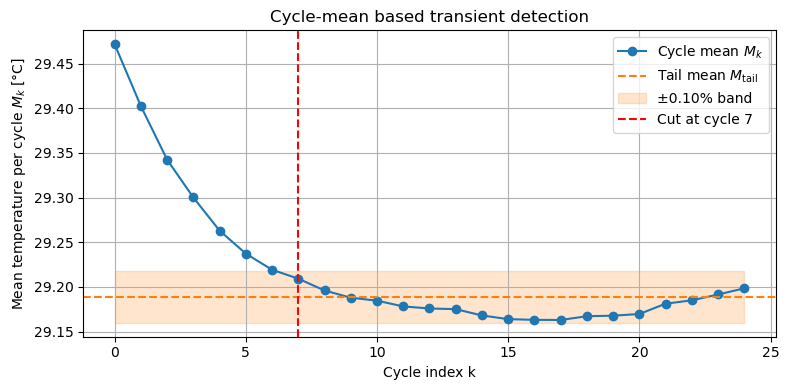

Thermistor 2
Detected stabilization at cycle 7 (t ≈ 140.1 s, removed 1847 samples, 28.0% of data).


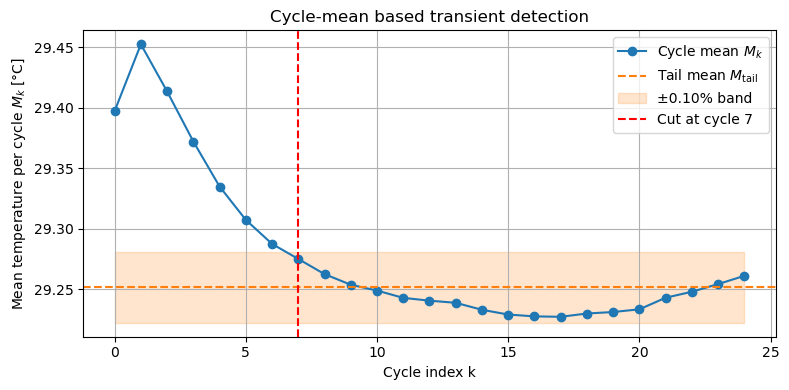

Thermistor 3
Detected stabilization at cycle 7 (t ≈ 140.1 s, removed 1847 samples, 28.0% of data).


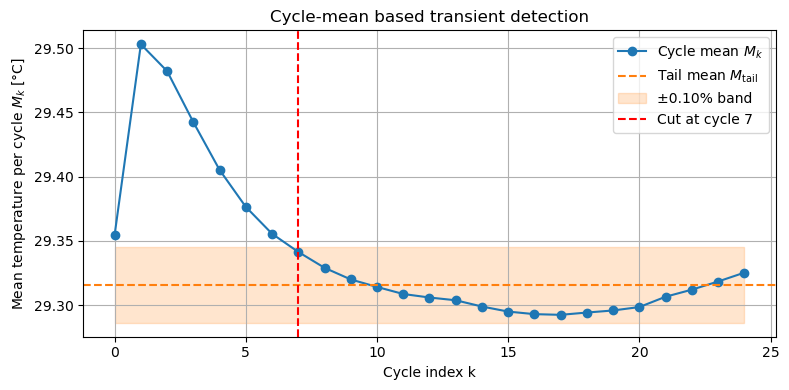

Thermistor 4
Detected stabilization at cycle 7 (t ≈ 140.1 s, removed 1847 samples, 28.0% of data).


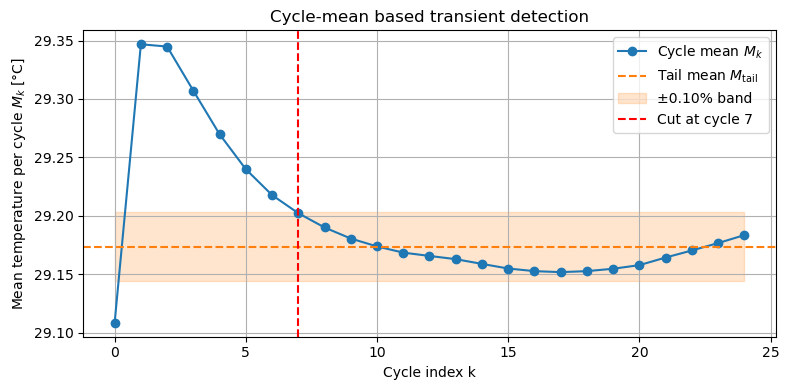

Thermistor 5
Detected stabilization at cycle 8 (t ≈ 160.0 s, removed 2110 samples, 31.9% of data).


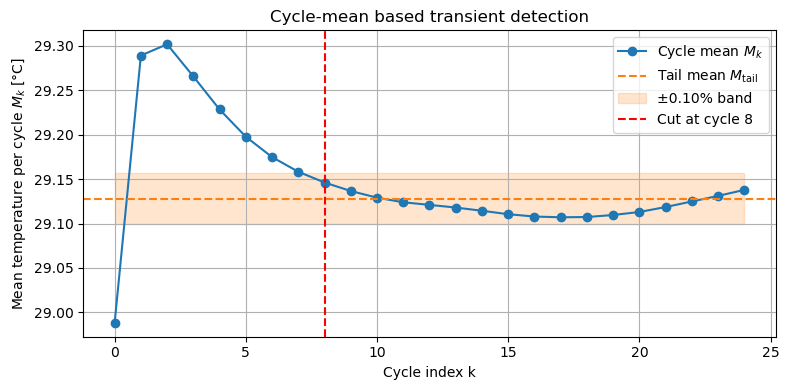

Thermistor 6
Detected stabilization at cycle 8 (t ≈ 160.0 s, removed 2110 samples, 31.9% of data).


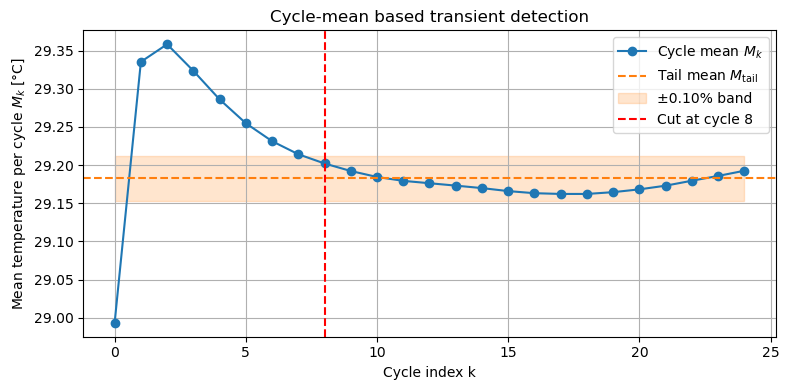

File: brass_T20s_run2.csv
Thermistor 0
Detected stabilization at cycle 26 (t ≈ 520.0 s, removed 6856 samples, 86.5% of data).


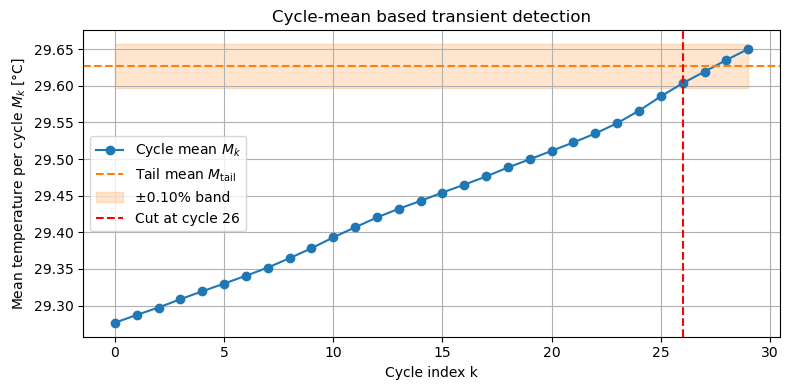

Thermistor 1
Detected stabilization at cycle 26 (t ≈ 520.0 s, removed 6856 samples, 86.5% of data).


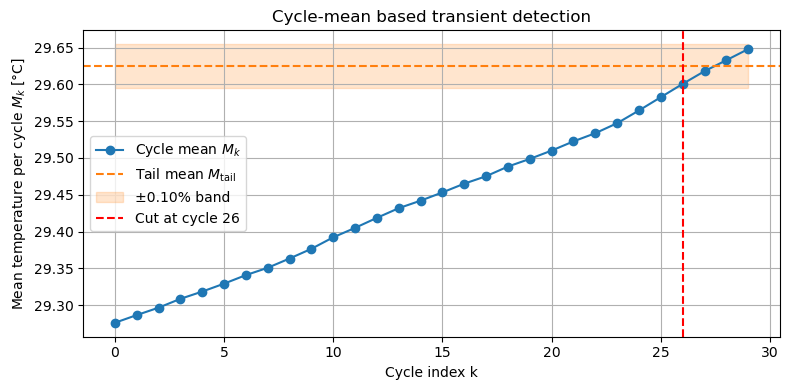

Thermistor 2
Detected stabilization at cycle 26 (t ≈ 520.0 s, removed 6856 samples, 86.5% of data).


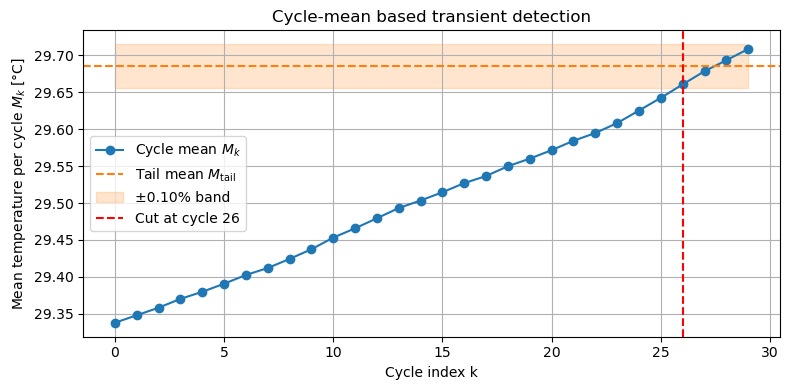

Thermistor 3
Detected stabilization at cycle 26 (t ≈ 520.0 s, removed 6856 samples, 86.5% of data).


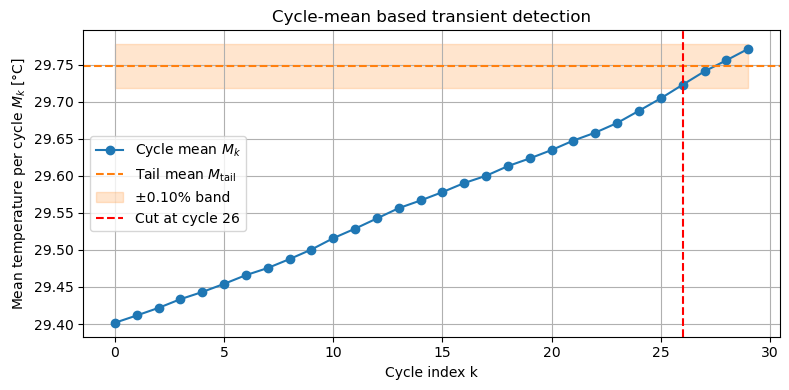

Thermistor 4
Detected stabilization at cycle 26 (t ≈ 520.0 s, removed 6856 samples, 86.5% of data).


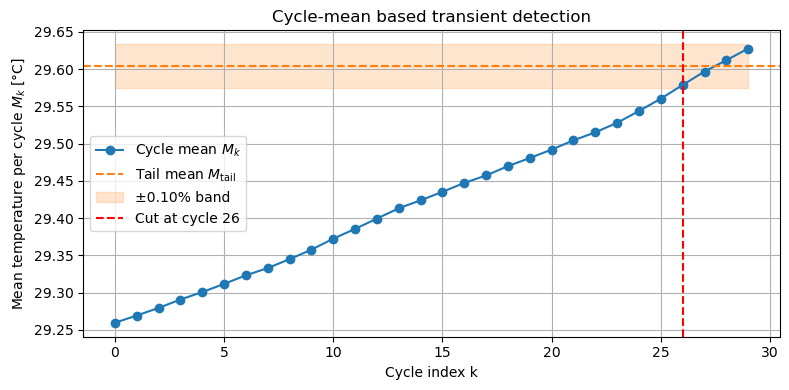

Thermistor 5
Detected stabilization at cycle 26 (t ≈ 520.0 s, removed 6856 samples, 86.5% of data).


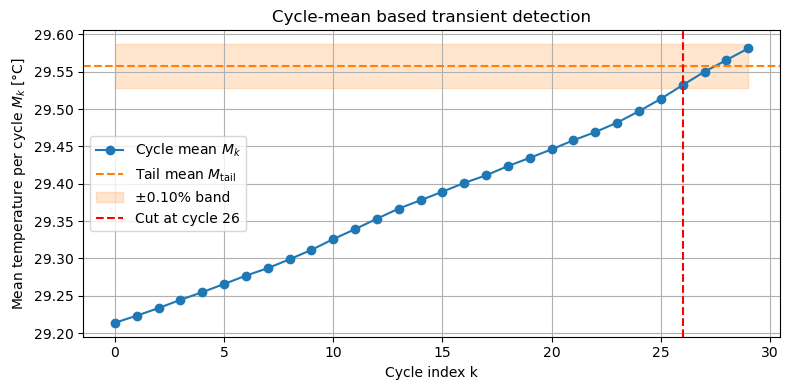

Thermistor 6
Detected stabilization at cycle 26 (t ≈ 520.0 s, removed 6856 samples, 86.5% of data).


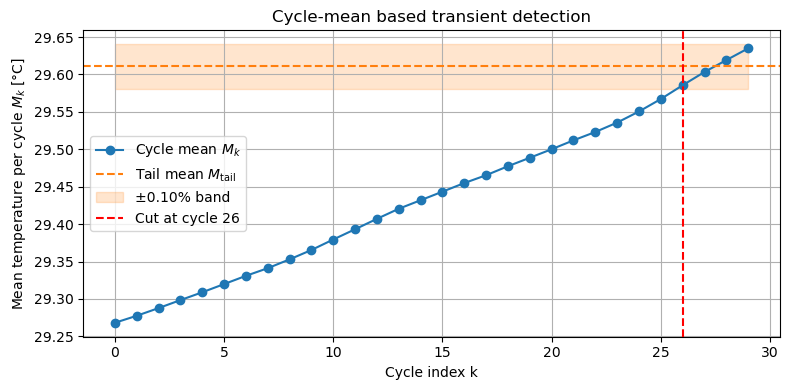

File: brass_T20s_run3.csv
Thermistor 0
Detected stabilization at cycle 31 (t ≈ 620.0 s, removed 8174 samples, 88.6% of data).


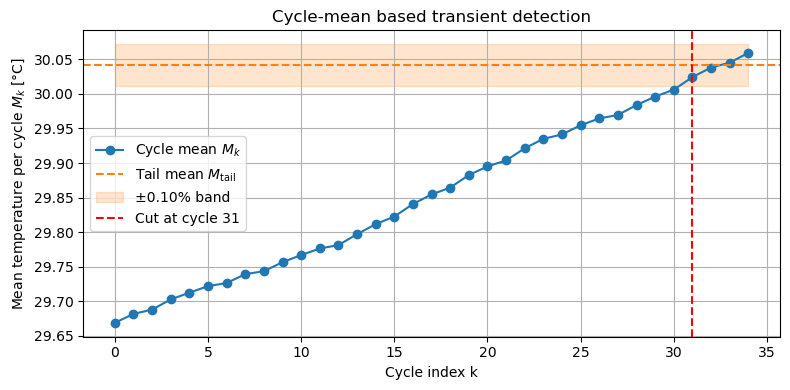

Thermistor 1
Detected stabilization at cycle 31 (t ≈ 620.0 s, removed 8174 samples, 88.6% of data).


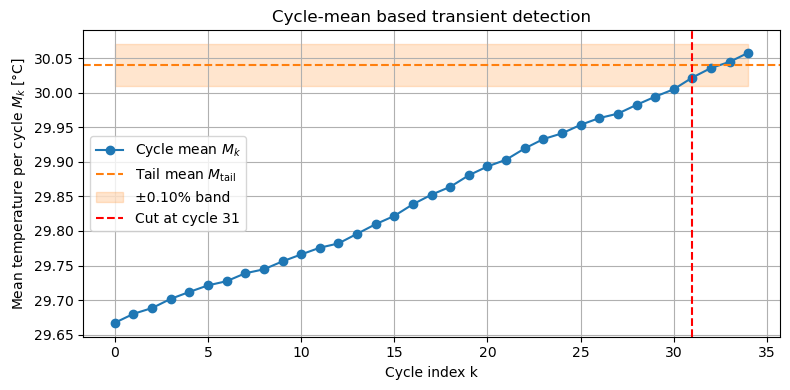

Thermistor 2
Detected stabilization at cycle 31 (t ≈ 620.0 s, removed 8174 samples, 88.6% of data).


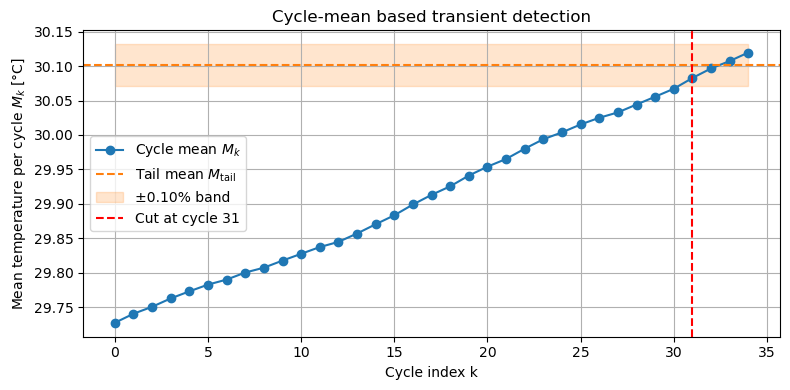

Thermistor 3
Detected stabilization at cycle 31 (t ≈ 620.0 s, removed 8174 samples, 88.6% of data).


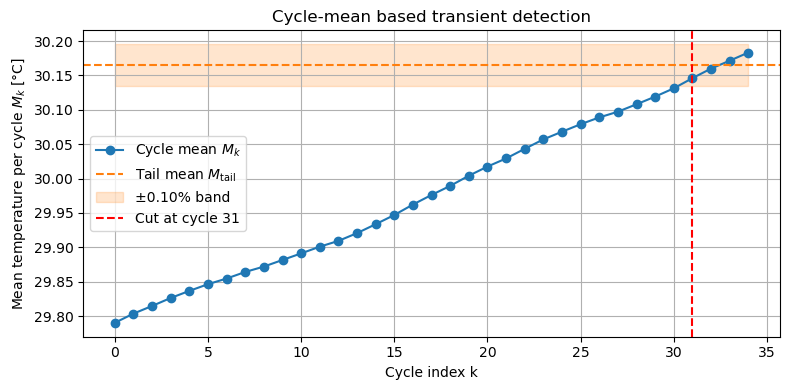

Thermistor 4
Detected stabilization at cycle 31 (t ≈ 620.0 s, removed 8174 samples, 88.6% of data).


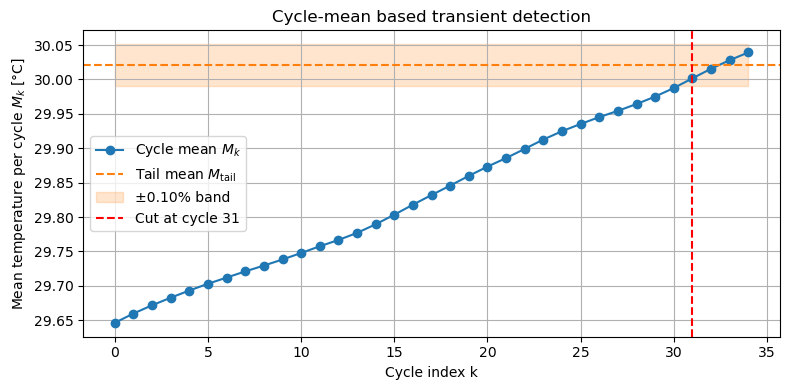

Thermistor 5
Detected stabilization at cycle 31 (t ≈ 620.0 s, removed 8174 samples, 88.6% of data).


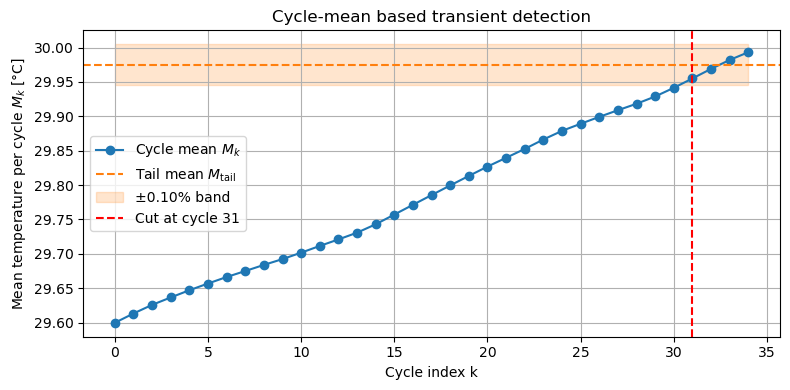

Thermistor 6
Detected stabilization at cycle 31 (t ≈ 620.0 s, removed 8174 samples, 88.6% of data).


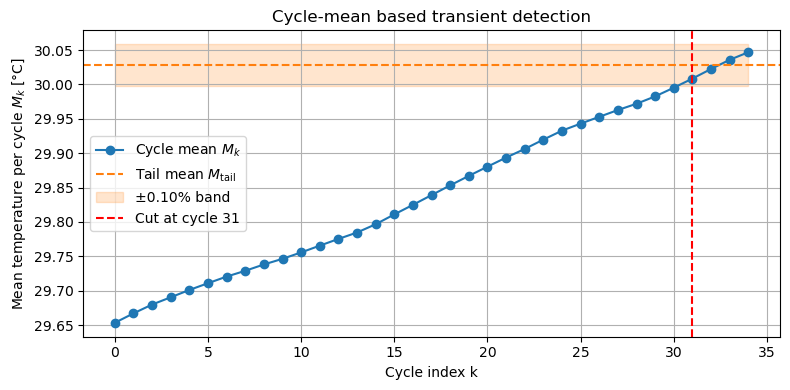

File: brass_T30s_run1.csv
Thermistor 0
No stable mean region found — returning full dataset.
Thermistor 1
No stable mean region found — returning full dataset.
Thermistor 2
Detected stabilization at cycle 17 (t ≈ 510.1 s, removed 6722 samples, 78.8% of data).


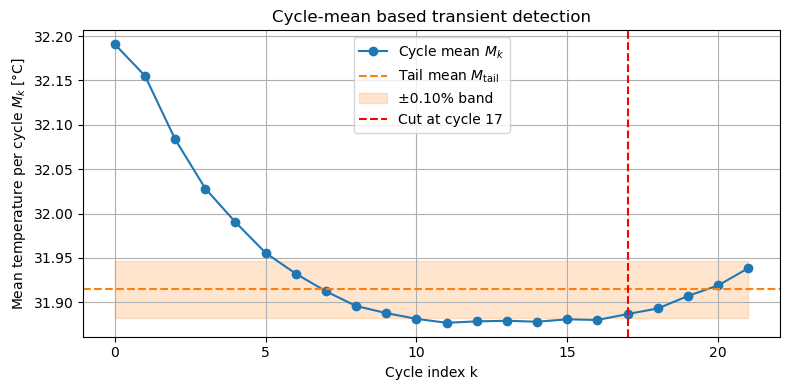

Thermistor 3
No stable mean region found — returning full dataset.
Thermistor 4
No stable mean region found — returning full dataset.
Thermistor 5
No stable mean region found — returning full dataset.
Thermistor 6
No stable mean region found — returning full dataset.
File: brass_T30s_run2.csv
Thermistor 0
No stable mean region found — returning full dataset.
Thermistor 1
No stable mean region found — returning full dataset.
Thermistor 2
No stable mean region found — returning full dataset.
Thermistor 3
No stable mean region found — returning full dataset.
Thermistor 4
No stable mean region found — returning full dataset.
Thermistor 5
No stable mean region found — returning full dataset.
Thermistor 6
No stable mean region found — returning full dataset.
File: brass_T60s_run1.csv
Thermistor 0
No stable mean region found — returning full dataset.
Thermistor 1
No stable mean region found — returning full dataset.
Thermistor 2
No stable mean region found — returning full dataset.
Thermistor

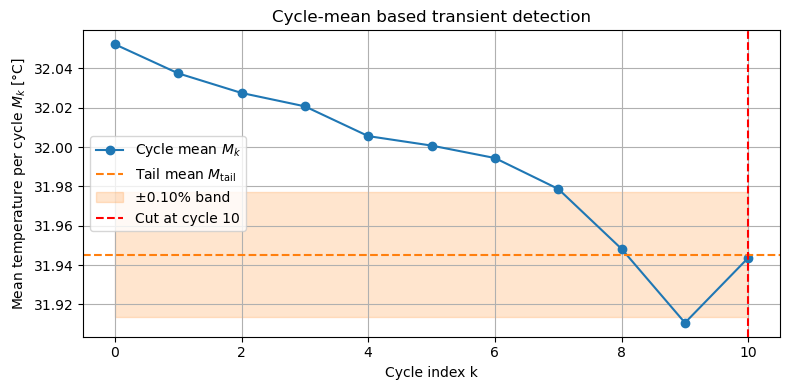

Thermistor 3
No stable mean region found — returning full dataset.
Thermistor 4
No stable mean region found — returning full dataset.
Thermistor 5
No stable mean region found — returning full dataset.
Thermistor 6
No stable mean region found — returning full dataset.
τ = 10.0 s → 2 runs
τ = 15.0 s → 2 runs
τ = 20.0 s → 3 runs
τ = 30.0 s → 2 runs
τ = 60.0 s → 2 runs


In [182]:
period_results = defaultdict(list)

for file in files:
    path = os.path.join(save_dir, file)
    print(rf'File: {file}')

    omega, gamma, unc_gamma, dphi, unc_dphi = analyse_dataset(path)

    # Convert ω back to period τ [s] so we can group runs
    tau = 2 * np.pi / omega

    period_results[tau].append((gamma, dphi))

# Quick check
for tau, runs in sorted(period_results.items()):
    print(f"τ = {tau:.2f} s → {len(runs)} runs")

In [183]:
D_gamma_list, D_gamma_err = [], []
D_phi_list,   D_phi_err   = [], []
taus_sorted = sorted(period_results.keys())

for tau in taus_sorted:
    runs = period_results[tau]
    gammas, dphis = zip(*runs)   # unpack list of (gamma, dphi)

    gammas = np.stack(gammas)    # shape (n_runs, n_therm)
    dphis  = np.stack(dphis)     # shape (n_runs, n_therm)

    # Mean and std across runs (per thermistor)
    gamma_mean = gammas.mean(axis=0)
    gamma_std  = gammas.std(axis=0, ddof=1)

    dphi_mean = dphis.mean(axis=0)
    dphi_std  = dphis.std(axis=0, ddof=1)

    # Distances x_i = i * delta_d [mm]
    n_therm = gamma_mean.shape[0]
    i_vals = np.arange(n_therm)
    x = i_vals * delta_d

    # ---------- D from attenuation: ln(γ) vs x ----------
    ln_gamma = np.log(gamma_mean)
    gamma_std = gammas.std(axis=0, ddof=1)
    sigma_ln_gamma = gamma_std / gamma_mean
    
    omega = 2 * np.pi / tau
    
    if np.all(sigma_ln_gamma == 0):
        # No scatter between runs → unweighted fit
        popt_g, pcov_g = curve_fit(
            linear,
            x,
            ln_gamma,
            maxfev=10000
        )
    else:
        popt_g, pcov_g = curve_fit(
            linear,
            x,
            ln_gamma,
            sigma=sigma_ln_gamma,
            absolute_sigma=True,
            maxfev=10000
        )
    
    k_gamma, c_gamma = popt_g
    unc_k_gamma, _   = np.sqrt(np.diag(pcov_g))
    
    D_gamma = omega / (2 * k_gamma**2)
    D_gamma_unc = np.abs(-omega / (k_gamma**3)) * unc_k_gamma


    D_gamma_list.append(D_gamma)
    D_gamma_err.append(D_gamma_unc)

    # D from phase: delta_phi vs x
    if np.all(dphi_std == 0):
         popt_p, pcov_p = curve_fit(
            linear,
            x,
            dphi_mean,
            maxfev=10000
            )
    else:
        popt_p, pcov_p = curve_fit(
            linear,
            x,
            dphi_mean,
            sigma=dphi_std,
            absolute_sigma=True,
            maxfev=10000
        )

    k_phi, c_phi = popt_p
    unc_k_phi, _ = np.sqrt(np.diag(pcov_p))
    
    D_phi = omega / (2 * k_phi**2)
    D_phi_unc = np.abs(-omega / (k_phi**3)) * unc_k_phi

    D_phi_list.append(D_phi)
    D_phi_err.append(D_phi_unc)

    print(f"τ = {tau:.1f} s:")
    print(f"  D_gamma = {D_gamma:.2f} ± {D_gamma_unc:.2f} mm²/s")
    print(f"  D_phi   = {D_phi:.2f} ± {D_phi_unc:.2f} mm²/s\n")


τ = 10.0 s:
  D_gamma = 0.31 ± inf mm²/s
  D_phi   = 0.31 ± inf mm²/s

τ = 15.0 s:
  D_gamma = 0.21 ± inf mm²/s
  D_phi   = 0.21 ± inf mm²/s

τ = 20.0 s:
  D_gamma = 0.16 ± inf mm²/s
  D_phi   = 0.16 ± inf mm²/s

τ = 30.0 s:
  D_gamma = 0.10 ± inf mm²/s
  D_phi   = 0.10 ± inf mm²/s

τ = 60.0 s:
  D_gamma = 0.05 ± inf mm²/s
  D_phi   = 0.05 ± inf mm²/s



/Users/yusufmspahi/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:931: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/Users/yusufmspahi/anaconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
